first let's import all the packages we'll need for this section. they are all standard steps from the sklearn library. except for category_encoders, which is an extension package of sklearn. it has an ordinal encoder that we will experiment with later on.

In [34]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
 

i like having our base dataset named "dataset", so let's name it that. which we will do by reading the stored variable from the other notebook. when i'm working in jupyter lab, i can simply switch the kernel of this notebook to use the kernel of the notebook where i imported the data. but if you are following along and don't have that functionality, you can always just add %store results_df to the end of the prior notebook, and %store -r results_df to load the variable back into kernel memory



In [35]:
# %store -r results_df
dataset = results_df
dataset

,received_dttm,dispatch_dttm,response_dttm,call_Type,fire_prevention_district,neighborhoods_analysis_boundaries,number_of_alarms,original_priority,priority,unit_type,rowid,response duration,travel time
0,2020-06-04 00:00:17,2020-06-04 00:02:09,2020-06-04 00:02:13,Medical Incident,None,Treasure Island,1,3,2,MEDIC,201560006-86,1.933333,0.066667
1,2020-06-04 00:00:17,2020-06-04 00:02:09,2020-06-04 00:04:08,Medical Incident,None,Treasure Island,1,3,2,ENGINE,201560006-E48,3.850000,1.983333
2,2020-06-04 00:00:17,2020-06-04 00:02:09,2020-06-04 00:04:12,Medical Incident,None,Treasure Island,1,3,2,MEDIC,201560006-RA48,3.916667,2.050000
3,2020-06-04 00:03:15,2020-06-04 00:05:48,2020-06-04 00:06:04,Medical Incident,6,Bernal Heights,1,2,2,MEDIC,201560012-94,2.816667,0.266667
4,2020-06-04 00:09:59,2020-06-04 00:11:53,2020-06-04 00:13:50,Outside Fire,3,Financial District/South Beach,1,3,3,ENGINE,201560019-E01,3.850000,1.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019-12-13 12:39:47,2019-12-13 12:42:33,2019-12-13 12:44:52,Elevator / Escalator Rescue,9,West of Twin Peaks,1,3,3,TRUCK,193471778-T15,5.083333,2.316667
996,2019-12-14 12:53:55,2019-12-14 12:57:01,2019-12-14 12:58:10,Medical Incident,9,West of Twin Peaks,1,2,2,ENGINE,193481776-E33,4.250000,1.150000
997,2019-10-03 14:54:35,2019-10-03 14:56:15,2019-10-03 14:56:21,Medical Incident,3,South of Market,1,3,3,MEDIC,192762497-77,1.766667,0.100000
998,2019-12-18 02:03:23,2019-12-18 02:05:57,2019-12-18 02:07:23,Medical Incident,4,Western Addition,1,2,3,ENGINE,193520192-E38,4.000000,1.433333


# data cleaning

first, let's take a look at what we are considering to be our 2 predicted quantities, "response duration"  and "travel time" (both defined in prior notebook) and check them for NaNs using Pandas methods isnull() and value_counts()

In [36]:
check = dataset['response duration'].isnull()
print(check.value_counts())

False    97862
True      2138
Name: response duration, dtype: int64


In [37]:
check = dataset['travel time'].isnull()
temp = dataset['travel time'].value_counts()
print(check.value_counts())

False    97862
True      2138
Name: travel time, dtype: int64


looks like there are some NaNs. probably of the same observations. we probably will have enough data that we can ignore/remove these observations, but i find it more elegant to replace them with a value that is closer to the truth. so instead let's calculate a mean and replace the NaNs with that value. recall that when the course filtered to times <15min the "response duration" distribution looked pretty gaussian, so adding more frequency to the mean shouldn't change the model. but we can try it both ways. 

In [38]:
goodMean = dataset['response duration'].mean(skipna = True)
dataset['response duration'] = dataset['response duration'].fillna(goodMean)

In [39]:
goodMean = dataset['travel time'].mean(skipna = True)
dataset['travel time'] = dataset['travel time'].fillna(goodMean)

In [40]:
dataset['response duration'].isnull().value_counts()

False    100000
Name: response duration, dtype: int64

even though earlier we discussed performing the analyis on both "travel time" and "response duration", we need to start focusing so we're not doing 2 different analyses at once. so in order to keep our distributions simple, let's focus on 'response duration' whose values are between 0 and 15 minutes.

In [41]:
dataset_raw = dataset
dataset = dataset_raw[dataset_raw['response duration'].between(0,15)]
dataset.columns

Index(['received_dttm', 'dispatch_dttm', 'response_dttm', 'call_Type',
       'fire_prevention_district', 'neighborhoods_analysis_boundaries',
       'number_of_alarms', 'original_priority', 'priority', 'unit_type',
       'rowid', 'response duration', 'travel time'],
      dtype='object')

what i realized after pouring through this data a few times is there can be several row enteries associated with the same incident. these rows will have the same "Received_dttm", but perhaps different unit_types or response times, as maybe several different types of units respond to the same incident but at different speeds. so what we will really be looking at is response speed per unit. anyway, as a way of making sure we don't have any duplicates of the data, i have also included the rowid, which we can run value_counts() on to make sure there are no duplicates.

In [42]:
dataset.shape

(98425, 13)

In [43]:
dataset['rowid'].value_counts()


192960389-B02    2
193054198-E01    2
192161266-E51    2
200150313-T15    2
193013155-E14    2
                ..
200072795-T19    1
193021046-B04    1
200223060-RS1    1
193612979-B05    1
193400350-68     1
Name: rowid, Length: 98410, dtype: int64

turns out there are some duplicates. they must have been in the dataset from the beginning. regardless, we can drop them easily.

In [44]:
dataset = dataset.drop_duplicates()
print(dataset.shape)


(98410, 13)


# Data Exploration (Visualizations)

at this point, the course goes on to immedately start the train/test split, encoding, and fitting a model. but one of the gravest errors in machine learning is building a model too early, before you've gotten really familiar with the data. so let's go outside the course and do some of that now. let's see if we can spot any correlations between the features of our observations, and the response duration, which is the variable we are trying to predict. presumably, because the course chose to track these features, there should be some. 
after all, instinctively, we would think that things like call type, number of alarms, and priority should all have some kind of impact on the response duration. to do this, let's plot the response duration against the elements of all the features. for simplicity, we will just collapse the data by using a pandas pivot table. this will just take an average of all response durations for each feature element

In [45]:
dataset.columns

Index(['received_dttm', 'dispatch_dttm', 'response_dttm', 'call_Type',
       'fire_prevention_district', 'neighborhoods_analysis_boundaries',
       'number_of_alarms', 'original_priority', 'priority', 'unit_type',
       'rowid', 'response duration', 'travel time'],
      dtype='object')

In [46]:
def plotAgainst(dataset,column, y_axis):
    dataset_piv = pd.pivot_table(dataset, index = column)
    dataset_piv = dataset_piv.reset_index()
    dataset_piv = dataset_piv.sort_values(by = y_axis)
    plt.scatter(dataset_piv[column],dataset_piv[y_axis])
    label = (y_axis, ' vs. ', column)
    plt.title(label)

In [47]:
dataset_columns = dataset.columns

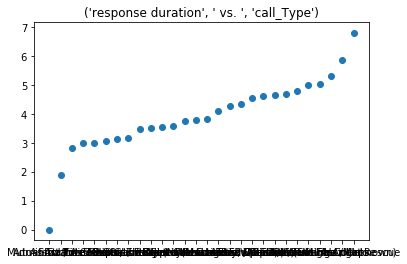

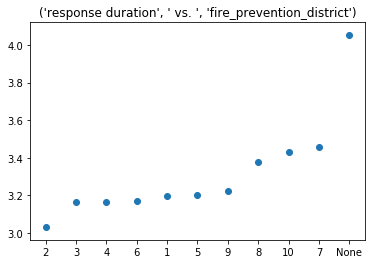

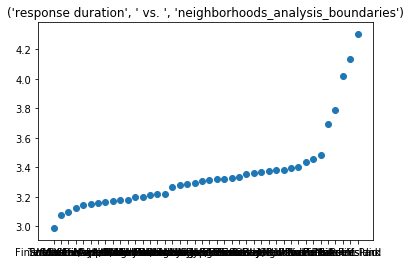

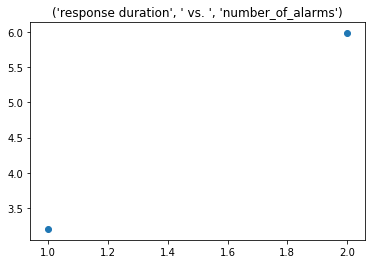

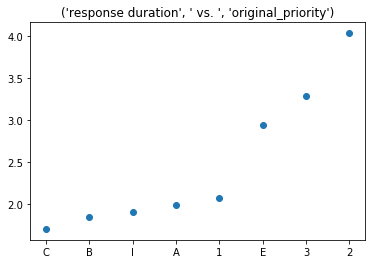

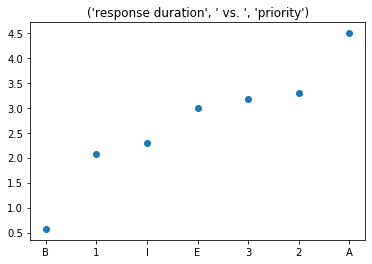

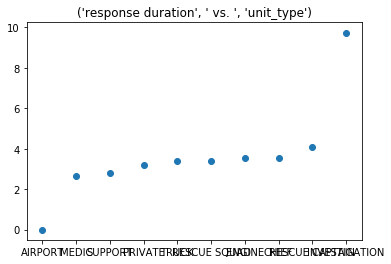

In [48]:
cols_to_plot = ['call_Type', 'fire_prevention_district','neighborhoods_analysis_boundaries', 'number_of_alarms', 'original_priority', 'priority','unit_type']

for i in range(len(cols_to_plot)):
    plt.figure()
    plotAgainst(dataset,cols_to_plot[i],'response duration') 
    plt.show()

so we've learned a few things from this, before even building models. all the columns that the courses uses to predict the response duration are correlated to it in some way. i'm a bit surprised that neighborhood and district seem to have a strong correlation. i would think that the fire department should be able to respond with equal speed to all parts of the city...isn't that kind of the point of the fire department? anyway, it will be interesting to see how that impacts the prediction. also, unit type seems to have an impact. some quick research reveals that "unit type" refers to the style of vehicle used to respond to the incident. i guess this is in some way related to the "call type", so the FD can make sure they have the appropriate equipment to respond to the incident.

anyway, given that we will be predicting a continuous quantity (time, in minutes), we will be using regression estimators, which require numerical inputs, which means we will need to encode our data. the course uses a straight one hot encoder for all features. but this is a possible divergence point. i would think that features like "priority" have a natural order to them. and it seems to be true somewhat. i would consider the two priority features as being more ordinal featres than categorical features. but the course treats them as categorical, so we'll follow suit.  but later on we will try with an Ordinal encoder. hence why we imported it earlier.


# Train/Test Split and one-hot encoding

standard steps for an 80/20 train/test split

In [49]:
X = dataset.drop(['travel time','response duration','dispatch_dttm','response_dttm', 'received_dttm', 'rowid'], axis=1)
y = dataset['response duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
ohe_train = OneHotEncoder(handle_unknown = 'ignore')
Xtrain_enc = ohe_train.fit_transform(X_train)
ohe_train.categories_

[array(['Administrative', 'Alarms', 'Assist Police',
        'Citizen Assist / Service Call',
        'Confined Space / Structure Collapse', 'Electrical Hazard',
        'Elevator / Escalator Rescue', 'Explosion',
        'Extrication / Entrapped (Machinery, Vehicle)', 'Fuel Spill',
        'Gas Leak (Natural and LP Gases)', 'HazMat', 'High Angle Rescue',
        'Industrial Accidents', 'Marine Fire', 'Medical Incident',
        'Mutual Aid / Assist Outside Agency', 'Odor (Strange / Unknown)',
        'Other', 'Outside Fire', 'Smoke Investigation (Outside)',
        'Structure Fire', 'Traffic Collision', 'Train / Rail Fire',
        'Train / Rail Incident', 'Vehicle Fire', 'Water Rescue',
        'Watercraft in Distress'], dtype=object),
 array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'None'],
       dtype=object),
 array(['Bayview Hunters Point', 'Bernal Heights', 'Castro/Upper Market',
        'Chinatown', 'Excelsior', 'Financial District/South Beach',
        'Glen Park',

In [51]:
ohe_test = OneHotEncoder(categories = ohe_train.categories_, handle_unknown = 'ignore')
Xtest_enc = ohe_test.fit_transform(X_test)
df_map = pd.DataFrame({'original column':X.columns,
                       'feature labels':ohe_train.categories_})

In [52]:
ohe_test.categories_

[array(['Administrative', 'Alarms', 'Assist Police',
        'Citizen Assist / Service Call',
        'Confined Space / Structure Collapse', 'Electrical Hazard',
        'Elevator / Escalator Rescue', 'Explosion',
        'Extrication / Entrapped (Machinery, Vehicle)', 'Fuel Spill',
        'Gas Leak (Natural and LP Gases)', 'HazMat', 'High Angle Rescue',
        'Industrial Accidents', 'Marine Fire', 'Medical Incident',
        'Mutual Aid / Assist Outside Agency', 'Odor (Strange / Unknown)',
        'Other', 'Outside Fire', 'Smoke Investigation (Outside)',
        'Structure Fire', 'Traffic Collision', 'Train / Rail Fire',
        'Train / Rail Incident', 'Vehicle Fire', 'Water Rescue',
        'Watercraft in Distress'], dtype=object),
 array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'None'],
       dtype=object),
 array(['Bayview Hunters Point', 'Bernal Heights', 'Castro/Upper Market',
        'Chinatown', 'Excelsior', 'Financial District/South Beach',
        'Glen Park',

just to make sure everything came out the right shape...ie that the training set or test set didn't end up with more feature labels than the other

In [53]:
print(Xtrain_enc.shape)
print(Xtest_enc.shape)

(78728, 107)
(19682, 107)


in order to judge our model performance against a standard baseline, let's see how good our predictions might be if we just predicted the average response duration every time.

In [54]:
avgDelay = np.full(y_test.shape, np.mean(y_train), dtype=float)
avgDelay

array([3.2047698, 3.2047698, 3.2047698, ..., 3.2047698, 3.2047698,
       3.2047698])

In [55]:
print(r2_score(y_test,avgDelay))
print(mean_squared_error(y_test, avgDelay, squared = False))


-3.393626604619726e-06
1.9816656193828424


so comparing the response durations of the test set against a baseline, we see that on average we are off by an average of about 2 minutes.

# create models and queue (divergence from course content)
in the course, we only work with one estimator, the simple linear regressor. but we'll be trying a bunch. so let's create a dataframe to hold the scores of each estimator we try, for quick comparison

In [56]:
if 'scores' not in locals():
    scores = pd.DataFrame({'model':[],
              'score':[]})
else:
    del scores
if 'rmse_scores' not in locals():
    rmse_scores = pd.DataFrame({'model':[],
              'RMSE score':[]})
else:
    del rmse_scores

this is where the course ends. it introduces the linear regression model, fits it, shows that it has a better RMSE than the baseline, and ends.
it is also where i will attempt to go deeper than the course and uncover some more interesting insights about the data.

the course only uses one estimator, but we should try a few to be sure we find the best one. estimators have different strengths for the nature of dataset they work on. for regression problems with our number of features and observations, we'll try all the relevant ones, with standard hyperparamters. we can tune these later on.

in the case of ridge and lasso, we can use the built-in cross-validation functionality so we know what hyperparmeters we should focus in on. feel free to turn down the verbosity to save screen space. i like it.

In [57]:
lr = linear_model.LinearRegression(fit_intercept=True, normalize=True)
sgdr = linear_model.SGDRegressor(max_iter=1000, tol =1e-3, verbose = 3)
ridge = linear_model.Ridge(alpha = 1)
ridge_cv = linear_model.RidgeCV(alphas = [1e-1,1e0,1e1])
lasso = linear_model.Lasso(alpha = 1)
lasso_cv = linear_model.LassoCV(alphas = [1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3], verbose = 3)
linSVR1 = LinearSVR(C=0.1, verbose = 3)
linSVR2 = LinearSVR(C=1, verbose = 3)
linSVR3 = LinearSVR(C=10, verbose = 3)
elNet = linear_model.ElasticNet(alpha = 1, l1_ratio = 0.5)

a cool part of my project will be to investigate feature importances. so we'll need a dataframe to hold those. 

In [58]:

importances = pd.DataFrame({'feature':ohe_train.get_feature_names()})
importances['feature category'] = importances['feature'].str[1]

# fit models to training set

there may be a more elegant approach to this, like possibly using pipelines. but for now, all we want to do is try each estimator on the dataset to see which comes out the strongest. so we'll make a queue of all the estimators we created eariler, fit each one to the training data, and then make predictions and record the scores for quick comparison. 

in the course, the scoring method chosen is the (root) mean squared error method. which makes sense, as that can be interpreted as an average number of minutes that the predictor is off by. but the built-in scoring method of all the estimators we will use is the r-squared. intuitively, this makes more sense to score models when the input is continuous, not ohe. regardless, we'll use both.

In [59]:
models = [lr,sgdr, ridge, ridge_cv, lasso, lasso_cv, linSVR1, linSVR2, linSVR3, elNet]
#models = [lr, sgdr, ridge_cv, lasso_cv, elNet]
#models = [lr, sgdr, ridge, lasso, elNet]

def fitPredictScore(modelQueue, X_train, y_train, X_test, y_test, scores, rmse_scores):
   
    for i in range(len(models)):
        print('fitting ',models[i])
        models[i].fit(X_train,y_train)    
        y_pred = models[i].predict(X_test)
        modelScore = models[i].score(X_test, y_test)
        scores = scores.append({'model':str(models[i].__class__.__name__),
                                  'score':modelScore},
                                  ignore_index = True)

        rmse_scores = rmse_scores.append({'model':str(models[i].__class__.__name__),
                                  'RMSE score':mean_squared_error(y_test, y_pred, squared = False)},
                                  ignore_index = True)
    return scores, rmse_scores


scores, rmse_scores = fitPredictScore(models,Xtrain_enc, y_train, Xtest_enc, y_test,scores=pd.DataFrame(),rmse_scores = pd.DataFrame())

fitting  LinearRegression(normalize=True)
fitting  SGDRegressor(verbose=3)
-- Epoch 1
Norm: 3.58, NNZs: 107, Bias: 0.017589, T: 78728, Avg. loss: 1.668251
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 3.78, NNZs: 107, Bias: 0.018849, T: 157456, Avg. loss: 1.636333
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 3.86, NNZs: 107, Bias: 0.019695, T: 236184, Avg. loss: 1.633194
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 3.90, NNZs: 107, Bias: 0.020049, T: 314912, Avg. loss: 1.631407
Total training time: 0.23 seconds.
-- Epoch 5
Norm: 3.96, NNZs: 107, Bias: 0.020726, T: 393640, Avg. loss: 1.630698
Total training time: 0.29 seconds.
-- Epoch 6
Norm: 4.06, NNZs: 107, Bias: 0.021902, T: 472368, Avg. loss: 1.629633
Total training time: 0.35 seconds.
-- Epoch 7
Norm: 4.07, NNZs: 107, Bias: 0.022085, T: 551096, Avg. loss: 1.629190
Total training time: 0.43 seconds.
-- Epoch 8
Norm: 4.12, NNZs: 107, Bias: 0.022785, T: 629824, Avg. loss: 1.628482
Total training time: 0.53 seconds

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(<MemoryView of 'ndarray' at 0x21911ba4558>, 0.0, 25.056691238484703, 1)
(<MemoryView of 'ndarray' at 0x21911ba4708>, 0.0, 25.056691238484703, 1)
(<MemoryView of 'ndarray' at 0x21911ba48b8>, 0.0, 25.056691238484703, 1)
(<MemoryView of 'ndarray' at 0x21911ba4a68>, 0.0, 25.056691238484703, 1)
(<MemoryView of 'ndarray' at 0x21911ba4c18>, 0.002808308374369517, 25.056691238484703, 5)
(<MemoryView of 'ndarray' at 0x21911ba4dc8>, 7.9133268015575595, 25.056691238484703, 71)
(<MemoryView of 'ndarray' at 0x21911ba9048>, 15.267146300931927, 25.056691238484703, 115)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s


(<MemoryView of 'ndarray' at 0x21911ba4708>, 0.0, 24.922748626209618, 1)
(<MemoryView of 'ndarray' at 0x21911ba4558>, 0.0, 24.922748626209618, 1)
(<MemoryView of 'ndarray' at 0x21911ba8048>, 0.0, 24.922748626209618, 1)
(<MemoryView of 'ndarray' at 0x21911ba81f8>, 0.0, 24.922748626209618, 1)
(<MemoryView of 'ndarray' at 0x21911ba8558>, 0.002621013845782727, 24.922748626209618, 5)
(<MemoryView of 'ndarray' at 0x21911ba8708>, 8.142208119854331, 24.922748626209618, 58)
(<MemoryView of 'ndarray' at 0x21911ba88b8>, 19.456668911036104, 24.922748626209618, 115)
(<MemoryView of 'ndarray' at 0x21911ba4558>, 0.0, 24.948900979700323, 1)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.5s remaining:    0.0s


(<MemoryView of 'ndarray' at 0x21911ba4708>, 0.0, 24.948900979700323, 1)
(<MemoryView of 'ndarray' at 0x21911ba88b8>, 0.0, 24.948900979700323, 1)
(<MemoryView of 'ndarray' at 0x21911ba8708>, 0.0, 24.948900979700323, 1)
(<MemoryView of 'ndarray' at 0x21911ba8558>, 0.002458373171975836, 24.948900979700323, 5)
(<MemoryView of 'ndarray' at 0x21911ba81f8>, 7.250614246848272, 24.948900979700323, 63)
(<MemoryView of 'ndarray' at 0x21911ba8048>, 21.94155094627058, 24.948900979700323, 209)
(<MemoryView of 'ndarray' at 0x21911ba4708>, 0.0, 25.021059196220126, 1)
(<MemoryView of 'ndarray' at 0x21911ba4558>, 0.0, 25.021059196220126, 1)
(<MemoryView of 'ndarray' at 0x21911ba8048>, 0.0, 25.021059196220126, 1)
(<MemoryView of 'ndarray' at 0x21911ba81f8>, 0.0, 25.021059196220126, 1)
(<MemoryView of 'ndarray' at 0x21911ba8558>, 0.002898216189350933, 25.021059196220126, 5)
(<MemoryView of 'ndarray' at 0x21911ba8708>, 7.4491329831653275, 25.021059196220126, 72)
(<MemoryView of 'ndarray' at 0x21911ba88b8>

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


fitting  LinearSVR(C=0.1, verbose=3)
[LibLinear]fitting  LinearSVR(C=1, verbose=3)
[LibLinear]fitting  LinearSVR(C=10, verbose=3)
[LibLinear]

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fitting  ElasticNet(alpha=1)


In [60]:
print(scores.sort_values(by='score', ascending = False))

              model     score
0  LinearRegression  0.186078
2             Ridge  0.186039
3           RidgeCV  0.186036
5           LassoCV  0.180891
1      SGDRegressor  0.179902
7         LinearSVR  0.141865
8         LinearSVR  0.138006
6         LinearSVR  0.135936
4             Lasso -0.000003
9        ElasticNet -0.000003


In [61]:
print(rmse_scores.sort_values(by='RMSE score'))


   RMSE score             model
0    1.787808  LinearRegression
2    1.787851             Ridge
3    1.787855           RidgeCV
5    1.793497           LassoCV
1    1.794579      SGDRegressor
7    1.835725         LinearSVR
8    1.839848         LinearSVR
6    1.842055         LinearSVR
4    1.981666             Lasso
9    1.981666        ElasticNet


the first thing to note is that in general, these r-square values look quite poor. obviously, what is a "good" vs "bad" r-square depends on the problem and the data, but intuitively i thought these estimators could do better. 

finally, it looks like the basic linear regressor and the ridge_cv (with alpha of 0.1) had the best scores - both the highest r-square and the lowest RMSE. this is probably why the course chose to introduce just the simple linear regressor. but the good news is that using this estimator instead of just predicing the average has improved the quality of our response duration prediction, from being off by 2 minutes, to being off by 1.73 minutes. still...this is only a 14% improvement in prediction quality. and if the average response duration is ~3 minutes, and we can only predict it within ~1.73 minutes, that's not very good. hopefully we can improve with other modifications to the model.

out of curiosity, let's check the best value of alpha used in the cross-validations.


In [62]:
print(ridge_cv.alpha_)
print(lasso_cv.alpha_)

1.0
0.001


both decently low. indicating that assigning weights to more features won't be heavily penalized. an alpha of 0 is just a linear regression. which makes sense in retrospect, recalling that our data is one-hot encoded. with 6 features, each with several labels, exploded out to 107 columns. we can expect that each of these columns will impact the prediction significantly. so if we expect all our features to contribute significantly, a basic linear regressor estimator makes sense as the strongest model. the correlations shown in the scatterplots earlier corroborate this.

a ridge estimator with alpha = 0.1 means that only slightly penalizing the weights of some features...which turns out not to help the predictibilty.

# compile feature importances

to examine the feature importances, i will use the permutation_importance() method, which takes an estimator, and iteratively re-fits it to the data with a new column dropped every time. the idea being that the most important features will do the greatest damage on the model when they are dropped

once the features have been assigned importances, we will append them to the dataframe of all the feature labels, so we can compare the importances given by each model

In [63]:
if 'importances' not in locals():
    importances = pd.DataFrame({'feature':encoder.get_feature_names()})
    importances['feature category'] = importances['feature'].str[1]

goodModels = [lr, sgdr, ridge_cv, lasso_cv]
goodModels = [lr]

for i in range(len(goodModels)):
    print('calculating feature importances for: ', goodModels[i])
    feIm = permutation_importance(goodModels[i],Xtrain_enc.toarray(), y_train, n_repeats = 3)
    importances[str(goodModels[i])] = feIm.importances_mean


calculating feature importances for:  LinearRegression(normalize=True)


In [64]:
importances.sort_values(by = 'LinearRegression(normalize=True)', ascending = False)

,feature,feature category,LinearRegression(normalize=True)
84,x4_2,4,0.107688
86,x4_A,4,0.049610
101,x6_MEDIC,6,0.045549
87,x4_B,4,0.029176
103,x6_RESCUE CAPTAIN,6,0.021724
...,...,...,...
83,x4_1,4,-0.000001
91,x5_1,5,-0.000001
47,x2_Haight Ashbury,2,-0.000002
95,x5_E,5,-0.000002


recall that our data is one-hot encoded. so it's not really feature importances we are looking at, but feature label importances. which doesn't help us very much. but it could be cool to see which single labels have the biggest impact on response duration

so far, the linear regressor is our strongest estimator, so we'll use that estimator's feature importances to sort by

In [65]:
print(importances.sort_values(by=['LinearRegression(normalize=True)'], ascending = False)[1:10])

                              feature feature category  \
86                               x4_A                4   
101                          x6_MEDIC                6   
87                               x4_B                4   
103                 x6_RESCUE CAPTAIN                6   
21                  x0_Structure Fire                0   
88                               x4_C                4   
99                          x6_ENGINE                6   
98                           x6_CHIEF                6   
3    x0_Citizen Assist / Service Call                0   

     LinearRegression(normalize=True)  
86                           0.049610  
101                          0.045549  
87                           0.029176  
103                          0.021724  
21                           0.018870  
88                           0.018344  
99                           0.008669  
98                           0.008539  
3                            0.006069  


looks like the most important labels are the "original priority" being assigned value "A" or"B" the call_type being assigned "medic", or the unit_type being assigned "MEDIC" or "RESCUE CAPTAIN".

still, the more vital information to extract would be which feature (not feature label) has the greatest bearing on response duration. in order to do that, we take an average of the importances over each feature category. i'm aware there may be a more model-rigorous way to do this, but this should satisfy our curiosity for now.

to do this, we can have pandas create a pivot table, aggregating the data by feature category, and taking an average

In [66]:
importances_pivot = pd.pivot_table(importances, index = 'feature category',aggfunc = 'mean')
print(importances_pivot.sort_values(by='LinearRegression(normalize=True)'))

                  LinearRegression(normalize=True)
feature category                                  
5                                         0.000155
2                                         0.000161
3                                         0.000487
1                                         0.000738
0                                         0.001360
6                                         0.010154
4                                         0.026447


this table is more helpful. reading from our best-performing estimator, we see that on average, the most important feature groups are 4 and 6. feature group 4 is the "original priority", and 6 is the unit_type. intuitively, this makes sense. 

# results discussion

i'm not an expert on how fire department calls are handled, but i imagine that at some point the dispatcher assigns a priority to each incident that gets called in. maybe this is assigned by a person, maybe it is assigned by an algorithm based on information that the dispatcher inputs. either way, it is logical that that would have a big impact on how quickly the fire department arrives on the scene. recall from the earlier scatterplot that we might have been able to guess this, given the strong visual correlation. also, that plot reveals the order of the original priority assignments, which seems to be (from highest to lowest) B, I, A, C, E, 3, 2. but this uncovers another problem. maybe the "original priority" is itself a output/target variable, using other features as its input. like the call_type, the neighborhood, or the number of alarms for example. in that case, another worthwhile exercise could be to remove it from the features (given that by its own right is correlated to the input features), or attempt to predict it using a different model. the same applies to the 2nd most important feature, the unit_type. to some degree, this would depend on the type of incident being reported. so maybe it too should be removed from the model to give it more versatility.

i think we can agree that some improvements can be made to the model. perhaps the greatest of which is to realize that there are 3 fields in the data that prehaps should not have been one-hot encoded. the "number of alarms" shouldn't need to be encoded at all. it's just an integer, which holds the number of alarms that the incident caused. in addition, given the discussion just presented, perhaps the two "priority" fields should be enoded not with a OHE, but with an ordinal encoder, given that the feature labels do have a natural "order". so let's try that next.

# try an ordinal encoder

this ordinal encoder we are using requires a list of dictionaries. it needs to be explicitly told what is the proper "ordering" of the feature labels. so we will give it that, for each column that we are applyind the encoder to

In [67]:
ordinalMapping = [{'col':'original_priority',
                   'mapping':
                            {'B':1,
                            'I':2,
                            'A':3,
                            'C':4,
                            'E':5,
                            '3':6,
                            '2':7}},
                     {'col':'priority',
                      'mapping':{
                              'E':1,
                              '3':2,
                              '2':3}},
                      {'col':'number_of_alarms',
                       'mapping':
                           {'1':1,
                            '2':2}
                              }]
                    
                                  

In [68]:
ordEnc = ce.OrdinalEncoder(mapping = ordinalMapping)
Xtrain_opt = ordEnc.fit_transform(X_train)
Xtrain_opt = Xtrain_opt.astype({'original_priority':'int64','priority':'int64', 'number_of_alarms':'int64'})

Xtest_opt = ordEnc.fit_transform(X_test)
Xtest_opt = Xtest_opt.astype({'original_priority':'int64','priority':'int64', 'number_of_alarms':'int64'})

In [69]:
dataset['number_of_alarms'].value_counts()

1    98359
2       51
Name: number_of_alarms, dtype: int64

In [70]:
Xtrain_opt

,call_Type,fire_prevention_district,neighborhoods_analysis_boundaries,number_of_alarms,original_priority,priority,unit_type
720,Traffic Collision,8,Sunset/Parkside,-1,3,3,ENGINE
710,Medical Incident,6,Mission,-1,6,2,MEDIC
170,Medical Incident,7,Presidio,-1,6,2,ENGINE
354,Medical Incident,3,South of Market,-1,7,3,MEDIC
120,Medical Incident,1,Financial District/South Beach,-1,7,2,ENGINE
...,...,...,...,...,...,...,...
360,Medical Incident,2,South of Market,-1,6,1,RESCUE CAPTAIN
781,Medical Incident,2,Mission,-1,7,3,ENGINE
76,Medical Incident,2,Tenderloin,-1,7,3,MEDIC
879,Medical Incident,1,Nob Hill,-1,6,2,ENGINE


we still want to one hot encode all the other features, meaning we will have a combination of one-hot encoded data and ordinally encoded data. in order to transform different column groups separately, we need to use the ColumnTransformer. it's a simple tool where we just have to tell it which encoder to use on which columns

then we can use the column transformer to fit_transform the raw training and test data.

In [71]:
from sklearn.compose import ColumnTransformer
    
ordinal_features = ['number_of_alarms','original_priority','priority']
categorical_features = ['call_Type','fire_prevention_district', 'neighborhoods_analysis_boundaries', 'unit_type']

ohe_train = OneHotEncoder(handle_unknown = 'ignore')

colTrans_train = ColumnTransformer(transformers = [

    ('cat_train',ohe_train, categorical_features),
    ('ord',ordEnc,ordinal_features)
])

In [72]:
Xtrain_opt_enc = colTrans_train.fit_transform(Xtrain_opt)

ohe_train_categories = colTrans_train.named_transformers_['cat_train'].categories_

In [73]:


ohe_test = OneHotEncoder(categories = ohe_train_categories, handle_unknown = 'ignore')

colTrans_test = ColumnTransformer(transformers = [
    ('cat_test',ohe_test, categorical_features),
    ('ord',ordEnc,ordinal_features)
])

Xtest_opt_enc = colTrans_test.fit_transform(Xtest_opt)

In [74]:
print(Xtrain_opt_enc.shape)
print(Xtest_opt_enc.shape)

(78728, 94)
(19682, 94)


before, when all our features were one hot encoded, there was no need to apply any center/scaling because after encoding, the values in the columns would have all been either 0 or 1. now that we have some integer values in there, we need to center and scale the data before we fit any models to it.

there a few options of how to scale the data, so we'll try them all

then we can fit and predict all the models in our queue as before and append their scores to the scores dataframe

In [75]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

mms = MinMaxScaler()
mas = MaxAbsScaler()
sts = StandardScaler(with_mean = False)

Xtrain_enc_opt_scaled = sts.fit_transform(Xtrain_opt_enc)
Xtest_enc_opt_scaled = sts.fit_transform(Xtest_opt_enc)


In [76]:
print(Xtrain_enc_opt_scaled.shape)
print(Xtest_enc_opt_scaled.shape)
print(y_test.shape)

(78728, 94)
(19682, 94)
(19682,)


In [77]:
models = [lr,sgdr,ridge_cv,lasso_cv,elNet]
models = [lr, ridge_cv]
scores, rmse_scores = fitPredictScore(models,Xtrain_enc_opt_scaled,y_train,Xtest_enc_opt_scaled, y_test, scores, rmse_scores)
    
print(scores)
print(rmse_scores)

fitting  LinearRegression(normalize=True)
fitting  RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
               model     score
0   LinearRegression  0.186078
1       SGDRegressor  0.179902
2              Ridge  0.186039
3            RidgeCV  0.186036
4              Lasso -0.000003
5            LassoCV  0.180891
6          LinearSVR  0.135936
7          LinearSVR  0.141865
8          LinearSVR  0.138006
9         ElasticNet -0.000003
10  LinearRegression  0.070349
11           RidgeCV  0.070350
    RMSE score             model
0     1.787808  LinearRegression
1     1.794579      SGDRegressor
2     1.787851             Ridge
3     1.787855           RidgeCV
4     1.981666             Lasso
5     1.793497           LassoCV
6     1.842055         LinearSVR
7     1.835725         LinearSVR
8     1.839848         LinearSVR
9     1.981666        ElasticNet
10    1.910687  LinearRegression
11    1.910686           RidgeCV


unfortunately, these did not help our scores. nor did they help the SVR estimators converge. this surprises me, as i would think that ordinal encoding of the appropriate features would make for a more accurate model. but i guess not.

# Further thoughts and discussion of possible next steps

in the course, the instructors claim victory by bettering the baseline predictions by ~0.3 minutes. but that's not very satisfying for me. but it seems like we've done all we can do with the features that the course has selected. they probably did their homework and found that these fields had the strongest correlation to the response duration. i'm sure there is also a strong correlation between response duration and the distance between the incident and the fire house that dispatched the unit. as well as time-of-day. but these seem a bit too obvious to me. i would rather find a connection to something lurking beneath the surface. hence my satisfaction with finding the connections between priority and unit type.

to satisfy my curiosity, i searched for other projects that are similar to what i've attempted. and i found one that's almost exactly the same. https://medium.com/crim/predicting-the-response-times-of-firefighters-using-data-science-da79f6965f93

in this project, Mr. Pecoraro endeavours to predict response times of the montreal fire department in a very similar way. he uncovers that his response times, too, are heavily influenced by the style of unit being dispatched. and not only that, he breaks the set down into "faster units" and "slower units" and finds that they have different distributions. hence, he splits up the dataset, and uses two different models - one for each style of unit. and his goal is also to beat a predictive model that simply predicts the average response time. he uses more features, like time-of-day. which is encouraging, and means maybe we can incorporate that feature into our predictive model here. a possible flaw in his approach is that he uses all calls before 2016 as his training set, and all calls after 2016 as his test set. this ignores any personnel/protocol/procedural/equipment changes that may have occured in the MPD between those two timespans. regardless, using machine learning algorithms, he was able to improve his prediction errors. quoting, "The mean absolute error (MAE) decreased from 17.8 seconds (baseline) to 15.7 seconds (XGBoost). When evaluating the model on the slower units only, the MAE decreased from 158 seconds to 85.6 seconds. When evaluating the faster units only, the error decreased from 16.9 seconds to 15.2 seconds."

this makes me feel better about my prediction accuracy improving by 14% from baseline.

regardless, as a final effort, let's see what happens when we incorporate received_dttm (time-of-day when call was received) as a continuous input feature. 


# adding timestamp of call as a continuous input feature

first, let's check to see if there's any correlation between the date and time of the call, and the response duration. i wouldn't think there should be. and even if there is, i would think it would be cyclical with a period of days or weeks, with slower response times ocurring during rush hours or holidays.

C:\Users\admin\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


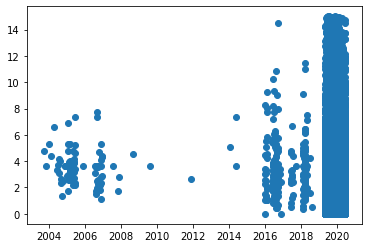

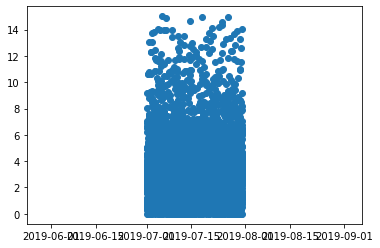

In [78]:


plt.figure()
plt.scatter(dataset['received_dttm'], dataset['response duration'])
plt.show()

recent_calls = dataset[dataset['received_dttm'].between('2019-07-01','2019-07-31')]
plt.figure()
plt.scatter(recent_calls['received_dttm'], recent_calls['response duration'])
plt.show()

looks like no visible correlation, but let's try it anyway.

a quick recap of steps:
- create new X and Y set from original dataset, but with received_dttm column included.
- convert received_dttm column to an integer timestamp (because sklearn models can't handle python datetimes as an input)
- use column transformer to one-hot encode all features except received_dttm (as int)
- perform feature scaling on timestamp column, using a max-absolute scaler (only one that can handle a sparse matrix)
- fit/predict/score the linear regressor estimator, and compare scores

In [79]:
X2 = dataset.drop(['travel time','response duration','dispatch_dttm','response_dttm', 'rowid'], axis=1)
y = dataset['response duration']


print(X.shape)
print(X2.shape)

(98410, 7)
(98410, 8)


In [80]:
import datetime as dt
import time as time
X2['received_dttm_int'] =X2['received_dttm'].values.astype(np.int64) // 10 ** 9
X2 = X2.drop(['received_dttm'], axis = 1)
X2.dtypes

call_Type                            object
fire_prevention_district             object
neighborhoods_analysis_boundaries    object
number_of_alarms                      int32
original_priority                    object
priority                             object
unit_type                            object
received_dttm_int                     int64
dtype: object

In [81]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [82]:
categorical_features = ['call_Type','fire_prevention_district', 'neighborhoods_analysis_boundaries', 'unit_type','number_of_alarms','original_priority','priority']
continuous_features  = ['received_dttm_int']

ohe_train = OneHotEncoder(handle_unknown = 'ignore')

colTrans = ColumnTransformer(transformers = [
    ('cat',ohe_train, categorical_features)], remainder = 'passthrough')

X2_train_enc = colTrans.fit_transform(X2_train)

ohe_train_categories = colTrans.named_transformers_['cat'].categories_
ohe_train_categories

[array(['Administrative', 'Alarms', 'Assist Police',
        'Citizen Assist / Service Call',
        'Confined Space / Structure Collapse', 'Electrical Hazard',
        'Elevator / Escalator Rescue', 'Explosion',
        'Extrication / Entrapped (Machinery, Vehicle)', 'Fuel Spill',
        'Gas Leak (Natural and LP Gases)', 'HazMat', 'High Angle Rescue',
        'Industrial Accidents', 'Marine Fire', 'Medical Incident',
        'Mutual Aid / Assist Outside Agency', 'Odor (Strange / Unknown)',
        'Other', 'Outside Fire', 'Smoke Investigation (Outside)',
        'Structure Fire', 'Traffic Collision', 'Train / Rail Fire',
        'Train / Rail Incident', 'Vehicle Fire', 'Water Rescue',
        'Watercraft in Distress'], dtype=object),
 array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'None'],
       dtype=object),
 array(['Bayview Hunters Point', 'Bernal Heights', 'Castro/Upper Market',
        'Chinatown', 'Excelsior', 'Financial District/South Beach',
        'Glen Park',

In [83]:
ohe_test = OneHotEncoder(categories = ohe_train_categories, handle_unknown = 'ignore')

colTrans = ColumnTransformer(transformers = [
    ('cat',ohe_test, categorical_features)], remainder = 'passthrough')

X2_test_enc = colTrans.fit_transform(X2_test)

print(X2_train_enc.shape)
print(X2_test_enc.shape)


(78728, 108)
(19682, 108)


In [84]:
mms = MinMaxScaler()
mas = MaxAbsScaler()
sts = StandardScaler(with_mean = False)

X2train_enc_opt_scaled = mas.fit_transform(X2_train_enc)
X2test_enc_opt_scaled = mas.fit_transform(X2_test_enc)

In [85]:
models = [lr, ridge]
scores, rmse_scores = fitPredictScore(models, X2train_enc_opt_scaled, y_train, X2test_enc_opt_scaled, y_test,scores, rmse_scores)
print(scores.sort_values(by='score',ascending = False))

fitting  LinearRegression(normalize=True)
fitting  Ridge(alpha=1)
               model     score
0   LinearRegression  0.186078
2              Ridge  0.186039
3            RidgeCV  0.186036
13             Ridge  0.186005
12  LinearRegression  0.185991
5            LassoCV  0.180891
1       SGDRegressor  0.179902
7          LinearSVR  0.141865
8          LinearSVR  0.138006
6          LinearSVR  0.135936
11           RidgeCV  0.070350
10  LinearRegression  0.070349
4              Lasso -0.000003
9         ElasticNet -0.000003


ok so it turns out adding the timestamp of the call as a feature still doesn't help the model prediction. looks like the course really did their homework and taught the best model, which also happened to be the simplest.

but let's try and go one step further. we know that the 2nd most important feature is unit_type. and we know Mr. Pecoraro got good results when he split this group up. so let's give that a try. first, let's take a look at the correlation between unit_type and response duration. we see that "investigations" tend to take much longer than other incidents. makes sense. let's see what the distribution is of that one unit_type



14.000000    2
11.016667    2
3.645492     2
0.000000     1
9.500000     1
11.133333    1
9.716667     1
11.416667    1
11.600000    1
13.900000    1
14.916667    1
3.816667     1
11.866667    1
5.483333     1
14.516667    1
8.050000     1
6.716667     1
9.650000     1
14.333333    1
10.016667    1
Name: response duration, dtype: int64

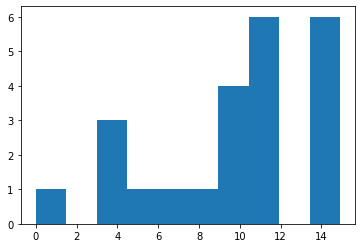

In [86]:
subset = dataset[dataset['unit_type']=='INVESTIGATION']
plt.hist(subset['response duration'])
subset['response duration'].value_counts()

that's a pretty unfriendly distribution. and implies that when the "investigation" unit is sent, response times can be quite long. but maybe that's because an "investigation" get dispatched to the same incident, alongside other, higher-priority units that can respond to incidents more quickly.

given the unfriendliness of this distribution, the model may improve if we remove these "investigation" observations from the training set. but then again, there are only 20 observations like this out of a set of 100k samples. so it probably won't change the model at all.

0.0    7
Name: response duration, dtype: int64

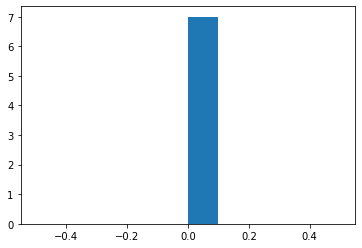

In [87]:
subset = dataset[dataset['unit_type']=='AIRPORT']
plt.hist(subset['response duration'])
subset['response duration'].value_counts()

this is another interesting connection. any unit types with the value "airport", all have zero as their response duration. this is probably because these units are responding to incidents at there airport, and there is a fire station inside the airport. pulling these out of the dataset would probably improve the model. but there are only 9 observations like this in a dataset of 100k observations. so it probably won't change at all.

well i think that's all the time i have for now. a few final thoughts before i sign off...

future ideas for a stronger model:
- either use another model to predict the priority of the indcident from other features, or remove it from the model.
- incorporate distance between fire stations and incident location as an input feature (would require GPS coordinates of all firehouses)
- check distribution of all unit_types for skewness. if necessary, split into two datasets (and hence two models), with each one being a group of units. perhaps a "faster units" and "slower units" as Mr. Pecoraro has done
- in order to achieve a better model score, perhaps we could run a clustering model on the resonse_durations and cluster them into groups of "average speed", "above average", and "below average". then run a classification model on the input features to simply predict whether the response speed will be "fast", "average", or "slow". realistically, this may not have as impactful of an application as predicting a continuous response time in minutes, but all we care about is model score, this may help.

finally, thanks for following along with my work. if you have any questions or suggestions for improvement or new projects, please feel free to raise an issue on GitHub or email me at Benjamin.A.Cohen.90@gmail.com.

some ideas for future projects, from my hobbies:
- prediction of "sonic coincidences" (when one song unintentionally sounds similar to another) using spotify data
- analysis of bike makes/models/sales using Strava data